This notebook analyses the pubmed search terms

**Modelling AND consciousness**

In [1]:
terms = "Modelling AND consciousness"

In [2]:
# imports

# region wise analysis imports
import folium
from folium.plugins import MarkerCluster

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

# topic analysis imports and word cloud imports
import pandas as pd 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
import re
import numpy as np
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from wordcloud import WordCloud

# sns plots

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# network visualization

from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot


In [3]:
# EDIT THIS CELL

pre_cleaned_processed_db = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/topics/modelling_and_consciousness/ready_MOD_CON_DF_pre_cleaned_processed"
big_df = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/topics/modelling_and_consciousness/uni_MOD_CON_DF_bigdf"

img_name = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/topics/modelling_and_consciousness/MOD_CON_word_cloud.jpeg"
circ_name = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/topics/modelling_and_consciousness/MOD_CON_circ.jpeg"

In [4]:
# DB imports
countries_dataframe = "/home/mrinalmanu/Desktop/analyse_pubmed_search_results/FINAL/countries_2"


# Region wise analysis

In [5]:
# notebook 4_primary_analyses_country_wise
df_n = pd.read_csv(pre_cleaned_processed_db)

# geographical coods
coods = df_n.loc[:, ['code', 'latitude', 'longitude']]
coods = coods.drop_duplicates(subset=['code'], keep='first')

# country wise stats
x_country = df_n.groupby(['code']).size().reset_index(name='country_count')
x_country = pd.merge(x_country, coods, left_on='code', right_on='code')



### Continent wise summary

In [6]:
# continent wise stats

# country info
iso_info = pd.read_csv(countries_dataframe)

x_continent = pd.merge(x_country, iso_info, left_on='code', right_on='code')

del x_continent['timezones']
del x_continent['capital']

y_x = x_continent.groupby('continent', as_index=False)['country_count'].sum()

y_y = x_continent.groupby('continent', as_index=False)['latitude'].mean()

y_z = x_continent.groupby('continent', as_index=False)['longitude'].mean()
y_continent = pd.merge(pd.merge(y_x,y_y,on='continent'),y_z,on='continent')

# drop NAs

x_continent = x_continent[x_continent['latitude'].notna()]
x_continent = x_continent[x_continent['longitude'].notna()]

# normalise counts
x_continent["country_count_norm"] = x_continent["country_count"] / x_continent["country_count"].max()

# continent summary
y_continent

,continent,country_count,latitude,longitude
0,Africa,45,3.410364,16.002189
1,America,11,18.220833,-66.590149
2,Asia,343,24.101494,88.026682
3,Europe,446,49.797164,14.587260
4,North America,361,28.118617,-94.327296
5,Oceania,91,-33.087477,154.330553
6,South America,45,-23.255632,-63.429618


In [7]:

# Create a world map to show distributions of researchers and their contributions

#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(x_continent)):
        lat = x_continent.iloc[i]['latitude']
        long = x_continent.iloc[i]['longitude']
        radius = float(x_continent.iloc[i]['country_count_norm'])*100# bubble map parameter
        popup_text = """continent : {}<br>
                    a) total contributions for the given topic : {}
                    b) percentage contribution : {} % <br>"""
        popup_text = popup_text.format(x_continent.iloc[i]['name'],
                                   x_continent.iloc[i]['country_count'], 
                                       round(x_continent.iloc[i]['country_count_norm']*100, 2)
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

### Top 20 major contributors

The country_count column represents number of researchers affiliated with a given country/ institute in a country.

In [8]:
stats = x_continent
stats.sort_values("country_count_norm", inplace=True, ascending=False)
del stats['latitude']
del stats['longitude']
stats.head(n=20)

,code,country_count,continent,name,country_count_norm
67,US,229,North America,United States,1.000000
10,CA,107,North America,Canada,0.467249
13,CN,98,Asia,People's Republic of China,0.427948
15,DE,84,Europe,Germany,0.366812
3,AU,83,Oceania,Australia,0.362445
66,TW,66,Asia,Taiwan,0.288210
47,NL,45,Europe,Kingdom of the Netherlands,0.196507
33,IT,44,Europe,Italy,0.192140
34,JP,43,Asia,Japan,0.187773
18,ES,40,Europe,Spain,0.174672


# Topic analyses of the papers

In [9]:

# Load in the final processed dataframe i.e. BIG_DF
df = pd.read_csv(big_df)

papers = df.loc[:, ['doi', 'year', 'title', 'abstract', 'author', 'affiliation_y', 'country', 'fuzzy_matched_QS']]
abstracts = papers.groupby(['abstract'], as_index=False, sort=False).agg(' | '.join)
abstracts.head(1)

,abstract,title,author,affiliation_y,country,fuzzy_matched_QS
0,The relative power of slow-delta oscillations ...,Closed-Loop Acoustic Stimulation During Sedati...,Ben Julian A Palanca | Ben Julian A Palanc...,Department of Brain and Cognitive Sciences Mas...,United States | Japan | United States | India ...,Massachusetts Institute of Technology (MIT) | ...


In [10]:
print("Total {} abstracts are available for the terms {}.".format(len(abstracts), terms))

Total 209 abstracts are available for the terms Modelling AND consciousness.


In [11]:
## PREPROCESSING
#Removing symbols from Abstracts
abstracts['Abstract_Cleaned'] = abstracts.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)

# tokenization
abstracts['Abstract_Cleaned'] = abstracts.apply(lambda row: (word_tokenize(row['Abstract_Cleaned'])), axis = 1)

# we have to remove stopwords
stop_words = set(stopwords.words('english'))
abstracts['Abstract_Cleaned'] = abstracts.apply(lambda row: ([w for w in row['Abstract_Cleaned'] if w not in stop_words]),axis=1)

# creating lemmas
lmtzr = WordNetLemmatizer()
abstracts['Abstract_Cleaned'] = abstracts.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['Abstract_Cleaned']]), axis=1)

copy = abstracts

# Creating Dictionary and Corpus

dictionary = corpora.Dictionary(abstracts['Abstract_Cleaned'])
texts = abstracts['Abstract_Cleaned']
corpus = [dictionary.doc2bow(text) for text in abstracts['Abstract_Cleaned']]

# Building LDA Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## INVERSE DOCUMENT FREQUENCIES FOR TOPICS

# inverse document frequencies for topics

abstracts = copy['abstract'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

# Mapping Top Topics & Abstracts

lda_model = LatentDirichletAllocation(n_components=9, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

# Affinity propogation on abstracts
#Testing affinity propogation on abstracts tfidf(experimental)

X = tfidf_abstracts
clustering = AffinityPropagation().fit(X)


# Building LDA Model

lda_model_17 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=17, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# visualization

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_17, corpus, dictionary)
vis

/home/mrinalmanu/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.173150  0.127530       1        1  27.834994
1     -0.231254 -0.129845       2        1  15.131107
2     -0.219957  0.190912       3        1   9.111183
5     -0.173540 -0.150820       4        1   8.963663
15    -0.154362 -0.189602       5        1   8.743389
12    -0.065679  0.017692       6        1   8.304456
14    -0.103452  0.181221       7        1   6.921372
13     0.010480 -0.041125       8        1   5.722447
7      0.072047 -0.005784       9        1   2.084121
16     0.136740 -0.012059      10        1   1.619615
8      0.138296 -0.013543      11        1   1.332262
4      0.124997 -0.003323      12        1   1.182091
9      0.132202 -0.022209      13        1   0.974356
3      0.122867  0.068371      14        1   0.948355
0      0.132317  0.004414      15        1   0.632332
6      0.128557 -0.011409      16        1   0.331647
10     0.122892 -0.010421      17        1   0.162612, topic_info=            Term        Freq       Total Category  logprob  loglift
584       health  312.000000  312.000000  Default  30.0000  30.0000
1683    Internet  150.000000  150.000000  Default  29.0000  29.0000
161        brain  241.000000  241.000000  Default  28.0000  28.0000
264          use  135.000000  135.000000  Default  27.0000  27.0000
108        sleep   82.000000   82.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3158  metastatic    0.008159    0.742279  Topic17  -8.8470   1.9110
3161  persuasion    0.008159    0.742279  Topic17  -8.8471   1.9109
3138     desired    0.008158    0.742287  Topic17  -8.8471   1.9109
3133        camp    0.008648    1.401946  Topic17  -8.7889   1.3332
3165     refugee    0.008279    2.066208  Topic17  -8.8324   0.9019

[834 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
428       1  0.897607      '
428       2  0.031495      '
428       8  0.047242      '
343       1  0.715296     's
343       4  0.168305     's
...     ...       ...    ...
342       6  0.079239   year
342       7  0.026413   year
1800      1  0.122746  young
1800      3  0.859220  young
2478     10  0.808961  youth

[1222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 2, 3, 6, 16, 13, 15, 14, 8, 17, 9, 5, 10, 4, 1, 7, 11])

Let's map the top matching topics with top matching abstracts, to generate a list of relevant papers.

In [12]:

lda_model = LatentDirichletAllocation(n_components=9, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

# first remove duplicated title, which was due to grouping the dataframe

c_c = copy['title'].str.split("|", 1, expand=True)
copy['title'] = c_c[0]
copy.head()

def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print('\n',"Topic %d:" % (topic_idx))
        print("Top Words: "," ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
            
no_top_words = 15
no_top_documents = 4     
title_list = copy['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
#display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)


nmf_model = NMF(n_components=9, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_abstracts)
nmf_W = nmf_model.transform(tfidf_abstracts)
nmf_H = nmf_model.components_

display_topics(nmf_H, nmf_W, tf_feature_names, title_list, no_top_words, no_top_documents)



 Topic 0:
Top Words:  the of and in to that is we for brain consciousness with as on this
Modeling an auditory stimulated brain under altered states of consciousness using the generalized Ising model. 
COALIA: A Computational Model of Human EEG for Consciousness Research. 
Matter, mind and consciousness: from information to meaning. 
Impaired consciousness is linked to changes in effective connectivity of the posterior cingulate cortex within the default mode network. 

 Topic 1:
Top Words:  propofol bis model concentration anesthesia pd compartment and effect was pharmacodynamic pk index were patients
Population pharmacokinetic-pharmacodynamic model of propofol in adolescents undergoing scoliosis surgery with intraoperative wake-up test: a study using Bispectral index and composite auditory evoked potentials as pharmacodynamic endpoints. 
Population Pharmacokinetic-Pharmacodynamic Modeling for Propofol Anesthesia Guided by the Bispectral Index (BIS). 
Pharmacokinetics and pharmacodyn

In [13]:
print("Based on the original keywords: {}, above topics were prevalant.".format(terms))

Based on the original keywords: Modelling AND consciousness, above topics were prevalant.


# Top 20s

In [14]:
# Load in the dataframe
df_n = pd.read_csv(pre_cleaned_processed_db)

### Top 20 affiliations

In [15]:
affiliation_grouping = df_n.groupby(['affiliation']).size().reset_index(name='affiliation_count')
affiliation_grouping.head(n=1)
stats = affiliation_grouping
stats.sort_values("affiliation_count", inplace=True, ascending=False)
stats.head(n=20)

,affiliation,affiliation_count
632,The Parkinsons Institute Sunnyvale USA,19
535,Project MindScope Allen Institute for Brain Sc...,19
409,Hospital Psiquiatric Universitari Institut Per...,13
96,Coma Science Group Cyclotron Research Centre a...,12
95,Coma Science Group Cyclotron Research Centre a...,11
441,Institute of Neurosciences and Medicine Helmho...,11
567,School of Acupuncturemoxibustion and Massage G...,10
499,Murdoch Childrens Research Institute Melbourne...,9
645,Trauma and Neurosurgery Program St Michaels Ho...,9
670,Wyle Integrated Science and Engineering Group ...,9


### Top 20 authors

In [16]:
author_grouping = df_n.groupby(['author']).size().reset_index(name='author_count')
author_grouping.head(n=1)
stats1 = author_grouping
stats1.sort_values("author_count", inplace=True, ascending=False)
stats1.head(n=20)

,author,author_count
254,Elise G Rowe,7
730,Naotsugu Tsuchiya,6
649,Marta I Garrido,5
243,Duan Li,4
701,Michele Farisco,4
159,Christoph Schmal,4
318,George A Mashour,4
462,Jihwan Myung,4
434,Jamie W Sleigh,3
669,Matthew A Diemer,3


### Top 20 journals

In [17]:
journal_grouping = df_n.groupby(['journal']).size().reset_index(name='journal_count')
journal_grouping.head(n=1)
stats2 = journal_grouping
stats2.sort_values("journal_count", inplace=True, ascending=False)
stats2.head(n=20)

,journal,journal_count
122,Neuroimage,93
56,Front Psychol,55
101,J Neurosci,54
140,Proc Natl Acad Sci U S A,34
81,J Clin Monit Comput,30
59,Front Syst Neurosci,30
98,J Med Internet Res,28
104,J Neurotrauma,28
131,PLoS One,27
80,J Clin Med,24


# University wise analysis (Top 100 CN and US)

In [18]:
# Load in the dataframe
df = pd.read_csv(big_df)

Including only Top 100 universities from US and ChinaArc

In [19]:
# converting ranges into a solid rank
  
split_range = lambda rank : [[int(y) for y in x.split('-')] if len(x.split('-')) == 2 else [int(x.split('+')[0])] for x in rank]

df['rank display'] = split_range(df['rank display'].astype(str))
df['rank display'] = pd.DataFrame(df['rank display'].values.tolist()).mean(1)

# get top 100
top_h = df[df['rank display'] <= 100]

# only china and us
codes = ['CN', 'US']

cleaned = top_h[top_h['country code'].isin(codes)]


In [20]:
papers = cleaned.loc[:, ['doi', 'year', 'title', 'abstract', 'author', 'affiliation_y', 'country', 'fuzzy_matched_QS', 'rank display']]
papers['abstract'] = papers['abstract'].astype(str)
title = papers.groupby(['title'], as_index=False, sort=False).agg(' | '.join)

# first remove duplicated title, which was due to grouping the dataframe

c_c = title['abstract'].str.split("|", 1, expand=True)

In [21]:
print("Total {} researchers hail from United States and China".format(len(cleaned)))

Total 3559 researchers hail from United States and China


In [22]:
print('{} publications from United States and China for the terms {}.'.format(len(title), terms))

198 publications from United States and China for the terms Modelling AND consciousness.


### Topic model for selected abstracts

#### Topic keywords

In [23]:
## PREPROCESSING
#Removing symbols from Abstracts
title['Abstract_Cleaned'] = title.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)

# tokenization
title['Abstract_Cleaned'] = title.apply(lambda row: (word_tokenize(row['Abstract_Cleaned'])), axis = 1)

# we have to remove stopwords
stop_words = set(stopwords.words('english'))
title['Abstract_Cleaned'] = title.apply(lambda row: ([w for w in row['Abstract_Cleaned'] if w not in stop_words]),axis=1)

# creating lemmas
lmtzr = WordNetLemmatizer()
title['Abstract_Cleaned'] = title.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['Abstract_Cleaned']]), axis=1)

copy = title

# Creating Dictionary and Corpus

dictionary = corpora.Dictionary(title['Abstract_Cleaned'])
texts = title['Abstract_Cleaned']
corpus = [dictionary.doc2bow(text) for text in title['Abstract_Cleaned']]


# Building LDA Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## INVERSE DOCUMENT FREQUENCIES FOR TOPICS

# inverse document frequencies for topics

title = copy['abstract'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(title)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_title = tfidf_vectorizer.transform(counts)

# Mapping Top Topics & Abstracts

lda_model = LatentDirichletAllocation(n_components=9, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_title)
lda_W = lda_model.transform(tfidf_title)
lda_H = lda_model.components_

# Affinity propogation on title
#Testing affinity propogation on title tfidf(experimental)

X = tfidf_title
clustering = AffinityPropagation().fit(X)


# Building LDA Model

lda_model_X = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=17, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



# we need to remove these excessively obvious term to see if the abstracts truly reflect the original searched key words
more_stopwords = [
    "research",
    "study",
    "examined",
    "associated",
    "studies",
    "Recent",
    "the",
    "of",
    "in",
    "for",
    "included",
    "present",
    "examine",
    "health",
    "human",
    "Although",
    "whether",
    "suggest",
    "use",
    "used"
]

copy['Abstract_Cleaned'] = copy.apply(lambda row: ([w for w in row['Abstract_Cleaned'] if w not in more_stopwords]),axis=1)

# creating lemmas
lmtzr = WordNetLemmatizer()
copy['Abstract_Cleaned'] = copy.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['Abstract_Cleaned']]), axis=1)

lem_text = copy['Abstract_Cleaned'].to_string()


/home/mrinalmanu/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


In [24]:
wc1 = WordCloud(background_color="white", width=600, height=400, min_font_size=15)
wc1.generate(lem_text)
wc1.to_file(img_name)

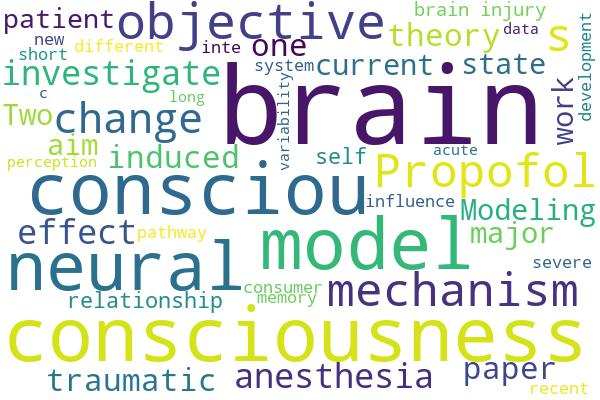

In [25]:
# visualization

pyLDAvis.enable_notebook()
vis_1 = pyLDAvis.gensim.prepare(lda_model_X, corpus, dictionary)
vis_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.111364 -0.129396       1        1  10.808595
3     -0.101882  0.078120       2        1   9.744312
4      0.089271 -0.072622       3        1   8.146422
0      0.083356 -0.060171       4        1   7.412919
13    -0.093093 -0.074908       5        1   5.908226
12     0.095040  0.208667       6        1   5.790672
10    -0.046493 -0.146144       7        1   5.693993
5      0.047194 -0.082825       8        1   5.527663
8      0.084661 -0.073597       9        1   5.439802
2     -0.119405  0.080601      10        1   5.101475
7     -0.155794 -0.072166      11        1   5.087819
9     -0.179544 -0.088132      12        1   5.060719
15     0.087608  0.164447      13        1   4.325389
14     0.096677 -0.076948      14        1   4.236027
11     0.101788  0.123026      15        1   4.198570
16    -0.237396  0.152036      16        1   3.981775
6      0.136648  0.070014      17        1   3.535622, topic_info=              Term         Freq        Total Category  logprob  loglift
1044             0  4919.000000  4919.000000  Default  30.0000  30.0000
108          sleep  2177.000000  2177.000000  Default  29.0000  29.0000
609       propofol  1935.000000  1935.000000  Default  28.0000  28.0000
760         health  1661.000000  1661.000000  Default  27.0000  27.0000
172   connectivity  2168.000000  2168.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
145             We   182.237394  3027.424862  Topic17  -4.8020   0.5321
114          study   182.751522  4020.597628  Topic17  -4.7991   0.2512
73        modeling   161.458595  3659.331667  Topic17  -4.9230   0.2215
10             EEG   150.971234  1592.973281  Topic17  -4.9902   0.9860
539      predicted   139.405107   647.690151  Topic17  -5.0699   1.8063

[1198 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
428       1  0.022640      '
428       2  0.094439      '
428       4  0.021346      '
428       5  0.008409      '
428       6  0.468963      '
...     ...       ...    ...
342      14  0.066688   year
342      15  0.062315   year
342      17  0.054663   year
2330      9  0.005737  youth
2330     17  0.992536  youth

[3132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 1, 14, 13, 11, 6, 9, 3, 8, 10, 16, 15, 12, 17, 7])

#### Topic summaries

In [26]:
print("Following topics were enriched for {} abstracts from US and CN, for the terms {}.".format(len(title), terms))

Following topics were enriched for 198 abstracts from US and CN, for the terms Modelling AND consciousness.


In [27]:

lda_model = LatentDirichletAllocation(n_components=9, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_title)
lda_W = lda_model.transform(tfidf_title)
lda_H = lda_model.components_

def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print('\n',"Topic %d:" % (topic_idx))
        print("Top Words: "," ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
            
no_top_words = 15
no_top_documents = 4     
title_list = copy['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
#display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

nmf_model = NMF(n_components=9, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_title)
nmf_W = nmf_model.transform(tfidf_title)
nmf_H = nmf_model.components_

display_topics(nmf_H, nmf_W, tf_feature_names, title_list, no_top_words, no_top_documents)



 Topic 0:
Top Words:  the of and to in that we is for consciousness with brain as on this
Modeling an auditory stimulated brain under altered states of consciousness using the generalized Ising model.
COALIA: A Computational Model of Human EEG for Consciousness Research.
Impaired consciousness is linked to changes in effective connectivity of the posterior cingulate cortex within the default mode network.
Reducing the Effect of Spurious Phase Variations in Neural Oscillatory Signals.

 Topic 1:
Top Words:  propofol bis model concentration pd compartment anesthesia and was effect were pharmacodynamic children pk patients
Population pharmacokinetic-pharmacodynamic model of propofol in adolescents undergoing scoliosis surgery with intraoperative wake-up test: a study using Bispectral index and composite auditory evoked potentials as pharmacodynamic endpoints.
Population Pharmacokinetic-Pharmacodynamic Modeling for Propofol Anesthesia Guided by the Bispectral Index (BIS).
Pharmacokinetics

### Quick stats

In [28]:
publication_data = cleaned
# Let's do a quick top 10s for the given lists

sns.set_style("white")
plt.figure(figsize=(10, 10), dpi=600)



<Figure size 6000x6000 with 0 Axes>

<Figure size 6000x6000 with 0 Axes>

#### Top 10 authors from US and CN combined


Text(0.5, 1.0, 'Top 10 Authors for the search terms Modelling AND consciousness')

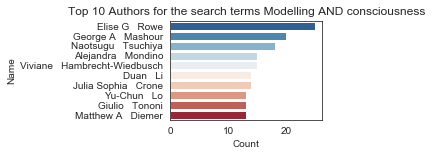

In [29]:
plt.subplot(2, 2, 1)

top10authors = pd.DataFrame.from_records(
    Counter(publication_data['author']).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors for the search terms {}".format(terms))


#### Top 10 Journals where researchers from US and CN publish.

Text(0.5, 1.0, 'Top 10 Journals for the search terms Modelling AND consciousness')

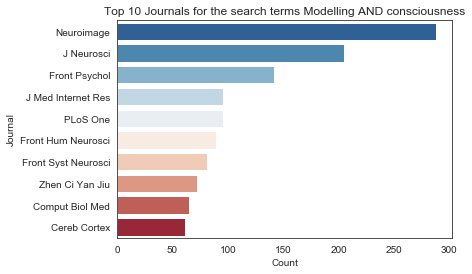

In [30]:
# TOP 10 Journals
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["journal"]).most_common(10),
    columns=["Journal", "Count"],
)
sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals for the search terms {}".format(terms))



#### TOP 10 Institutes involved

Text(0.5, 1.0, 'Top 10 Institutes for the search terms Modelling AND consciousness')

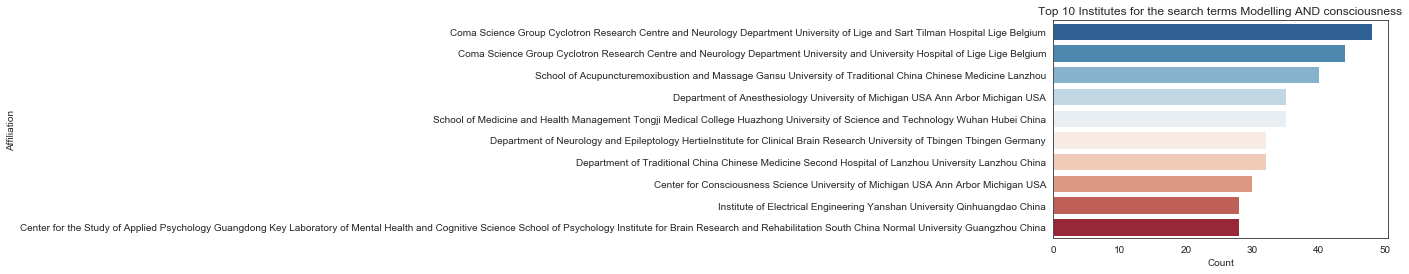

In [31]:
# TOP 10 Institutes involved
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["original_affiliation"]).most_common(10),
    columns=["Affiliation", "Count"],
)
sns.barplot(x="Count", y="Affiliation", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Institutes for the search terms {}".format(terms))


#### Contributions from ranked institutes

Text(0.5, 1.0, 'QS Ranked Institutes for the search terms Modelling AND consciousness')

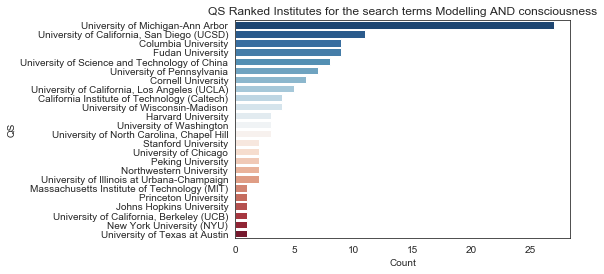

In [32]:
# Contributions from ranked institutes
high_filter = publication_data[publication_data["Token_Set_Ratio"] >= 85]
top10journals = pd.DataFrame.from_records(
    Counter(high_filter["fuzzy_matched_QS"]).most_common(),
    columns=["QS", "Count"],
)
sns.barplot(x="Count", y="QS", data=top10journals, palette="RdBu_r")
plt.title("QS Ranked Institutes for the search terms {}".format(terms))


#### Information about top 10 authors

In [33]:
group_p = publication_data.loc[:, ['pmid', 'year', 'title', 'abstract', 'author', 'original_affiliation', 'fuzzy_matched_QS', 'rank display']]
group_p["pmid"] = group_p["pmid"].astype(str)
group_p = group_p.groupby(['author'], as_index=False, sort=False).agg(' | '.join)
top_10_info = pd.merge(top10authors, group_p, left_on='Name', right_on='author')
del top_10_info["Name"]
del top_10_info["abstract"]
top_10_info

,Count,author,pmid,title,original_affiliation,fuzzy_matched_QS
0,25,Elise G Rowe,30356864 | 30356864 | 33262694 | 33262694 | 33...,Bayesian Model Selection Maps for Group Studie...,Monash Neuroscience of Consciousness Laborator...,Yale University | Yale University | Yale Unive...
1,20,George A Mashour,30529630 | 30959192 | 33664133 | 33664133 | 30...,"Relationship of critical dynamics, functional ...",Department of Anesthesiology University of Mic...,Yale University | Yale University | Yale Unive...
2,18,Naotsugu Tsuchiya,22375133 | 27517084 | 33262694 | 33262694 | 33...,The role of risk aversion in non-conscious dec...,Computation and Neural Systems California Inst...,California Institute of Technology (Caltech) |...
3,15,Alejandra Mondino,33664133 | 33664133 | 33664133 | 33664133 | 33...,Glutamatergic neurons in the preoptic hypothal...,Department of Anesthesiology University of Mic...,Yale University | Yale University | Yale Unive...
4,15,Viviane Hambrecht-Wiedbusch,33664133 | 33664133 | 33664133 | 33664133 | 33...,Glutamatergic neurons in the preoptic hypothal...,Center for Consciousness Science University of...,Yale University | Yale University | Yale Unive...
5,14,Duan Li,30959192 | 33664133 | 21993398 | 30959192 | 33...,Cortical dynamics during psychedelic and anest...,Center for Consciousness Science University of...,Yale University | Yale University | Yale Unive...
6,14,Julia Sophia Crone,27114177 | 27114177 | 25620493 | 27114177 | 27...,Testing Proposed Neuronal Models of Effective ...,Department of Psychology University of Califor...,Yale University | Yale University | Yale Unive...
7,13,Yu-Chun Lo,32714169 | 32714169 | 32714169 | 32714169 | 32...,Developmental Differences of Structural Connec...,Center for Advanced Study in the Behavioral Sc...,Stanford University | Yale University | Yale U...
8,13,Giulio Tononi,23845770 | 30788150 | 22593076 | 23845770 | 30...,Modeling resting-state functional networks whe...,Department of Psychiatry University of Wiscons...,Yale University | Yale University | Yale Unive...
9,13,Matthew A Diemer,26505744 | 28933884 | 31691984 | 31691984 | 26...,Unraveling the Complexity of Critical Consciou...,University of Michigan USA and Michigan USA St...,Yale University | Yale University | Yale Unive...


#### Publications for the give terms over time

In [34]:
print("Publications over time for the terms {}".format(terms))

Publications over time for the terms Modelling AND consciousness


(2010, 2020)

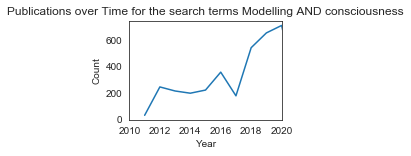

In [35]:
# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time for the search terms {}".format(terms))
plt.xlim([2010, 2020])


#### Network connectivity of authors

Which scientists publish together.

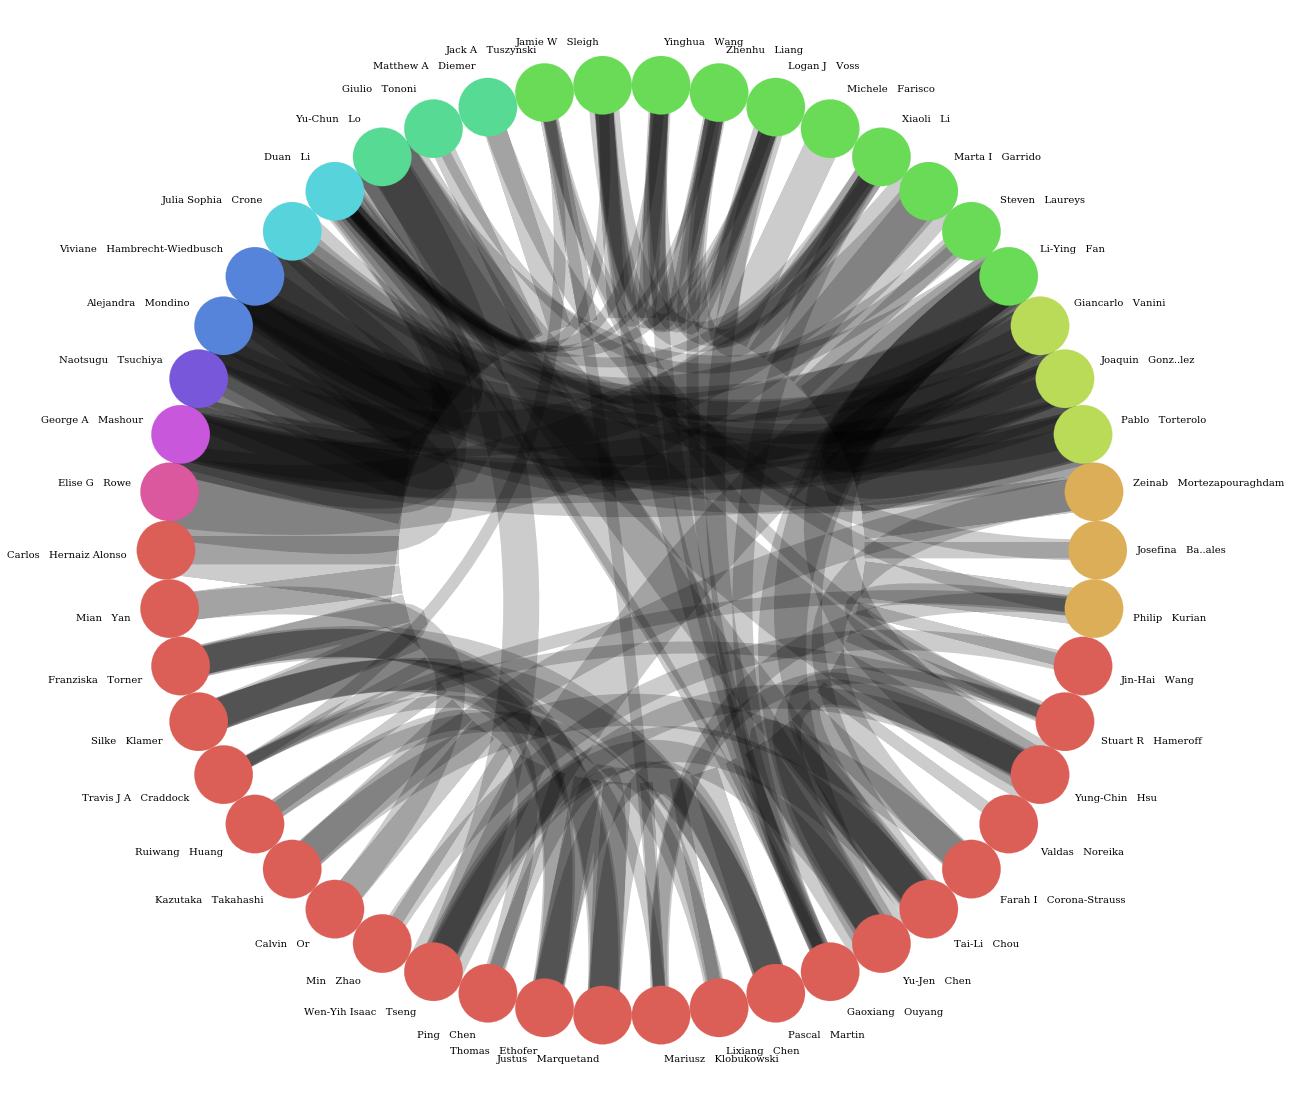

In [36]:
split_author = lambda rank : [[str(y.strip()) for y in x.split('|')] for x in rank]

# return a list of authors
authors_flat = [
    author
    for authors in split_author(copy["author"])
    for author in authors
]

authors = split_author(copy["author"])

# flatten list function

def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

# Extract author connections
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = flatten_list(author_connections)

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.node[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )


c = CircosPlot(
    G_50,
    dpi=600,
    node_grouping="publications",
    edge_width="Count",
    figsize=(20, 20),
    node_color="publications",
    node_labels=True,
)
c.draw()
plt.show()

In [37]:

plt.savefig(circ_name)

<Figure size 432x288 with 0 Axes>

Image is saved in the relevant folder.

#### Network analysis of authors

Which researcher has the most collaborations?
Who is essential in connecting to the other authors.

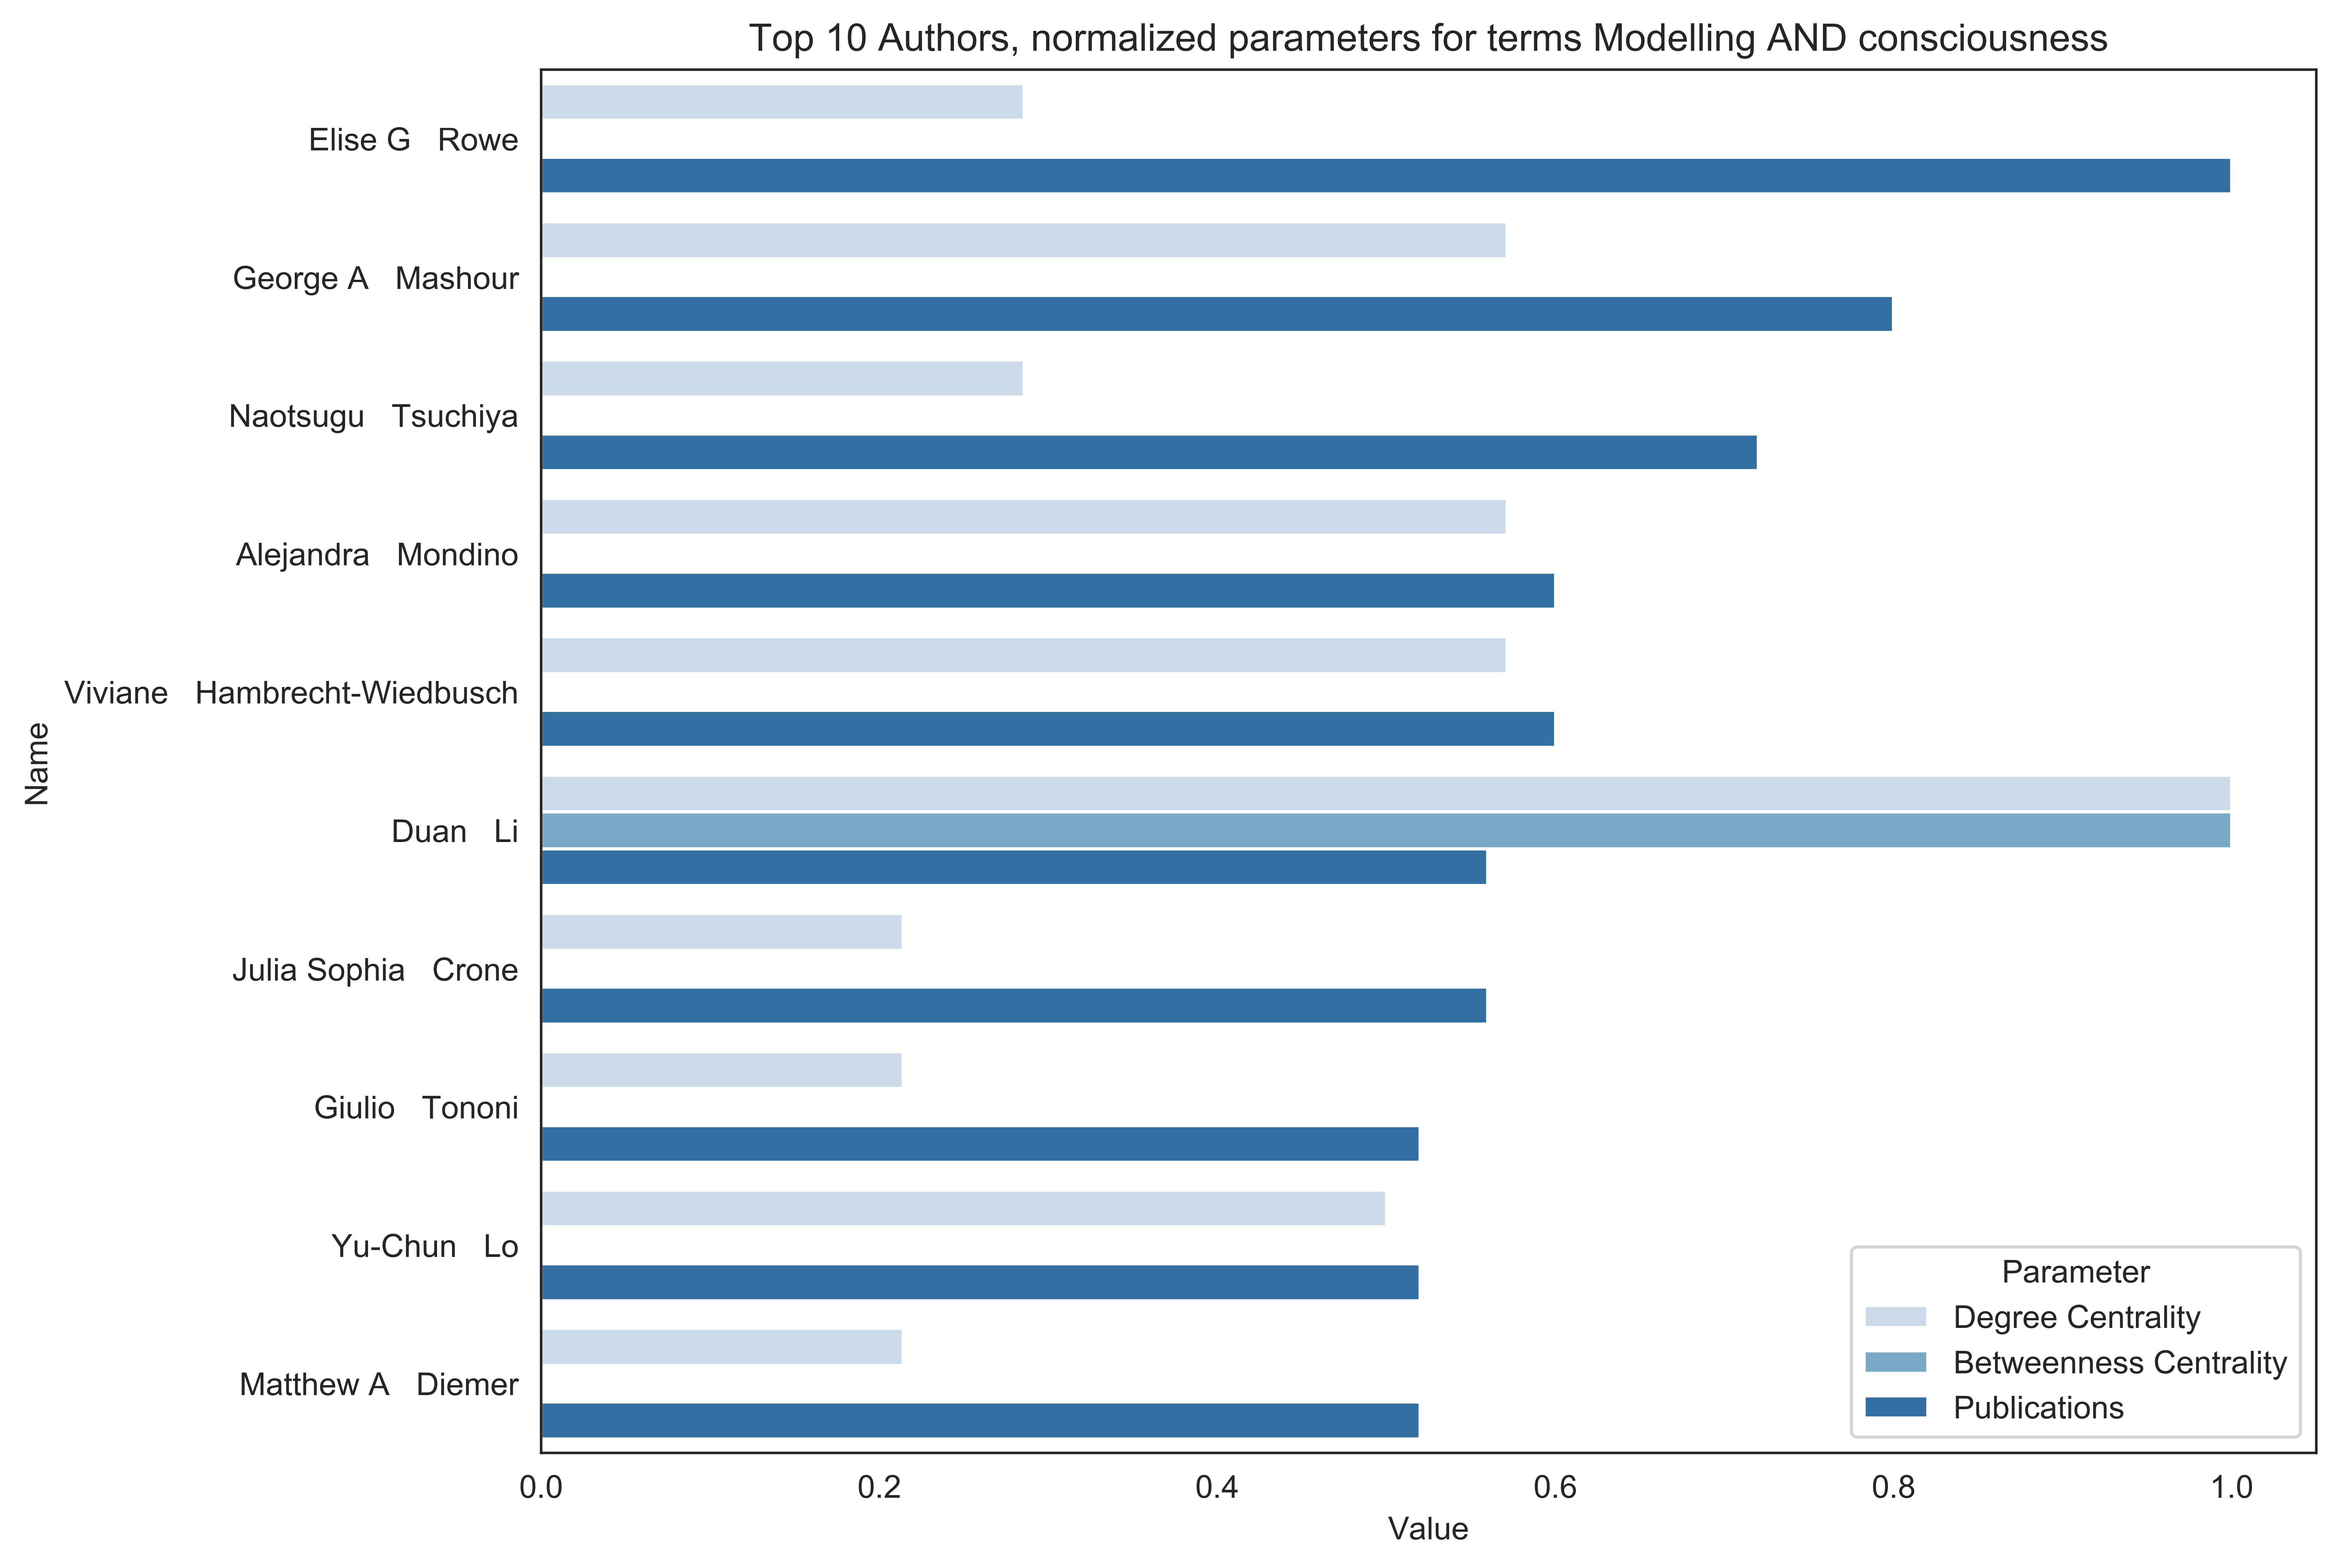

In [38]:
## Network analysis
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

top_df = pd.DataFrame.from_dict(
    [deg, bet, dict(Counter(authors_flat).most_common(50))]
).T
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters for terms {}".format(terms))
plt.show()

In [39]:
betweeness_name = circ_name.strip('.jpeg') + '_between.jpeg'
plt.savefig(betweeness_name)

<Figure size 432x288 with 0 Axes>

***